In [1]:
import os
import tensorflow as tf

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)
SEED = 42

def extract_family_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    family_genus_species = tf.strings.split(folder_name, "_")
    family = family_genus_species[-3]
    genus = family_genus_species[-2]
    species = family_genus_species[-2] + " " + family_genus_species[-1]

    return family, genus, species

def process_path(path, family_labels, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [224, 224])

    # Get the family, genus, and species labels
    family, genus, species = extract_family_genus_and_species_from_path(path)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    family_labels = set()
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract family, genus, and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                family, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique family, genus, and species names
                family_labels.add(family)
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, family_labels, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

# Usage
train_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
val_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)

2024-10-22 11:18:13.066446: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-22 11:18:13.066471: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-22 11:18:13.066476: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-22 11:18:13.066488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-22 11:18:13.066499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

2024-10-22 11:18:17.704966: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


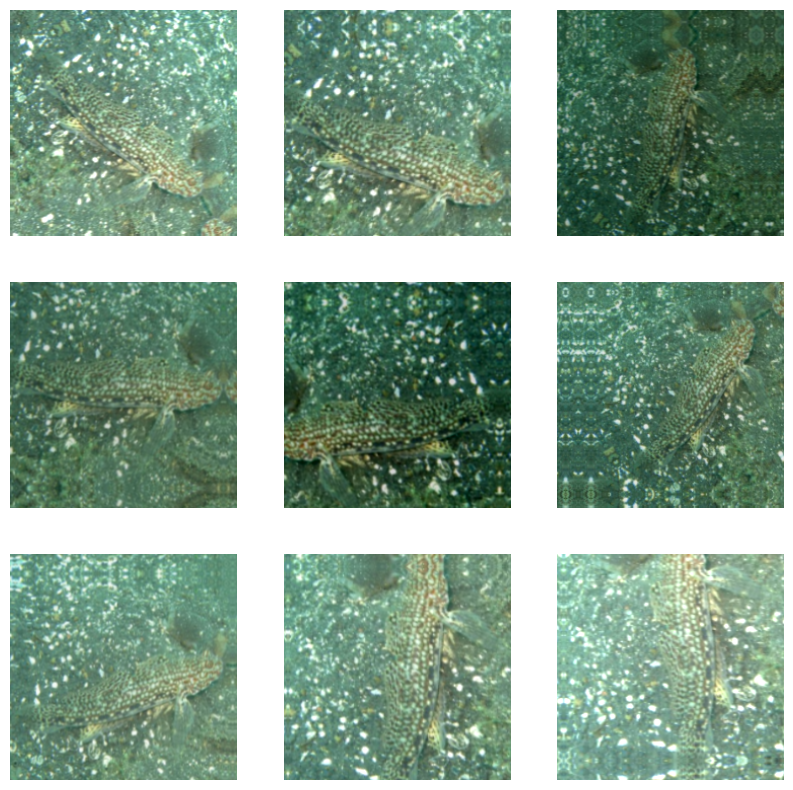

In [4]:
import matplotlib.pyplot as plt

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Define the inputs and apply augmentation
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

# Define attention mechanism
def apply_attention(inputs):
    attention_score = layers.Dense(1, activation='softmax')(inputs)
    attention_output = layers.Multiply()([inputs, attention_score])
    return attention_output

# Define family output
family_output = layers.Dense(len(family_labels), activation='softmax', name='family')(x)

# Apply attention to the family output concatenation
family_features = layers.Concatenate()([x, family_output])
family_features = apply_attention(family_features)

# Define genus output, using family features as additional input
genus_hidden = layers.Dense(256, activation='relu')(family_features)
genus_output = layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

# Apply attention to the genus output concatenation
genus_features = layers.Concatenate()([x, family_output, genus_output])
genus_features = apply_attention(genus_features)

# Define species output, using both family and genus features as additional input
species_hidden = layers.Dense(256, activation='relu')(genus_features)
species_output = layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

# Create the hierarchical model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])

# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ subtract[0][0]    │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2066)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,067 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 2066)      │          0 │ concatenate[0][0… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    529,152 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     11,565 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2111)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      2,112 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 2111)      │          0 │ concatenate_1[0]… │
│ (Multiply)          │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    540,672 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     14,649 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,701,899 (94.23 MB)

 Trainable params: 1,137,099 (4.34 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [6]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [7]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10


/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
2024-10-22 11:18:58.194141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - family_accuracy: 0.1834 - family_loss: 3.0032 - genus_accuracy: 0.1959 - genus_loss: 3.3770 - loss: 10.1267 - species_accuracy: 0.1589 - species_loss: 3.7466 - val_family_accuracy: 0.3950 - val_family_loss: 1.9113 - val_genus_accuracy: 0.5483 - val_genus_loss: 1.8695 - val_loss: 6.0103 - val_species_accuracy: 0.4848 - val_species_loss: 2.1898
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - family_accuracy: 0.4077 - family_loss: 1.9039 - genus_accuracy: 0.5636 - genus_loss: 1.7597 - loss: 5.7569 - species_accuracy: 0.4985 - species_loss: 2.0932 - val_family_accuracy: 0.5698 - val_family_loss: 1.4359 - val_genus_accuracy: 0.6775 - val_genus_loss: 1.2712 - val_loss: 4.1857 - val_species_accuracy: 0.6305 - val_species_loss: 1.4834
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - family_accuracy: 0.5186 - family_loss: 1.5269 - genus_accuracy: 0.6530 - genus_loss: 1.3288 - loss: 4.3512 - species_accuracy: 0.6216 - species_loss: 1

In [8]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - family_accuracy: 0.7687 - family_loss: 0.7188 - genus_accuracy: 0.8161 - genus_loss: 0.6022 - loss: 1.9836 - species_accuracy: 0.8221 - species_loss: 0.6628
Family Acc: 0.783
Genus Acc: 0.829
Species Acc: 0.830


In [9]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [10]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [11]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 67s 326ms/step - family_accuracy: 0.7031 - family_loss: 1.0357 - genus_accuracy: 0.7381 - genus_loss: 0.9886 - loss: 3.0567 - species_accuracy: 0.7452 - species_loss: 1.0324 - val_family_accuracy: 0.8142 - val_family_loss: 0.5957 - val_genus_accuracy: 0.8294 - val_genus_loss: 0.5943 - val_loss: 1.8368 - val_species_accuracy: 0.8246 - val_species_loss: 0.6352
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - family_accuracy: 0.7823 - family_loss: 0.7542 - genus_accuracy: 0.8375 - genus_loss: 0.6271 - loss: 2.0547 - species_accuracy: 0.8180 - species_loss: 0.6734 - val_family_accuracy: 0.8419 - val_family_loss: 0.5016 - val_genus_accuracy: 0.8557 - val_genus_loss: 0.5175 - val_loss: 1.5904 - val_species_accuracy: 0.8515 - val_species_loss: 0.5528
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 313ms/step - family_accuracy: 0.8270 - family_loss: 0.5922 - genus_accuracy: 0.8577 - genus_loss: 0.4993 - loss: 1.6255 - species_accuracy: 0.8567 - sp

In [14]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - family_accuracy: 0.9153 - family_loss: 0.2668 - genus_accuracy: 0.9084 - genus_loss: 0.3158 - loss: 0.9241 - species_accuracy: 0.9031 - species_loss: 0.3414
Family Acc: 0.917
Genus Acc: 0.906
Species Acc: 0.902


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, family_labels, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], [224, 224]) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


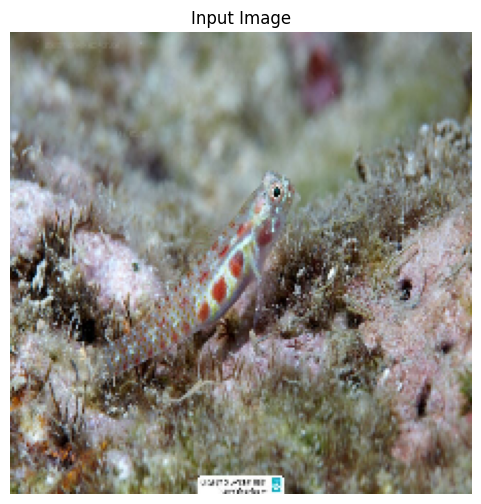

Top 3 Family Predictions:
b'Gobiidae': 0.9864
b'Tripterygiidae': 0.0061
b'Syngnathidae': 0.0044

Top 3 Genus Predictions:
b'Eviota': 0.9964
b'Ecsenius': 0.0010
b'Aioliops': 0.0005

Top 3 Species Predictions:
b'Eviota albolineata': 0.5023
b'Eviota atriventris': 0.2819
b'Eviota melasma': 0.0910


In [13]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/66367_web_Eviota_melasma_6.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3
)
